# Logistic Regression: Faceoff

What log-losses and perfectly separated data have to do with hockey sticks?

## Who ordered this?

As of this writing, Google search for "logistic regression tutorial" shows about 11.2M results. Why add another thing to this pile?

After reading a good number of articles, books and guides, I realized that most lack clear and intuitive explanations. Instead, they usually strive to be either practical, by showing how to run models, or as mathematically complete as possible, and as a consequence, basic concepts get buried underneath a forest of matrix algebra.

We will start by clearing up what seem to be common misconceptions.

Logistic regression is not:
- linear regression but with sigmoid curve instead of a straight line
- classification algorithm (but can be used for this)
- sigmoid curve "fit" of a decision boundary separating two classes of points in the x-y plane

## What _is_ a logistic regression?

Logistic regression is a regression model that returns a probability of a binary outcome (0 or 1), assuming that log of the odds is a linear combination of one or more inputs. Odds is a ratio between probability of outcome happening ($p$) and the probability of the outcome not happening ($1-p$). When we have one input or predictor, this starting assumption is mathematically expressed as:

$$\log\frac{p}{1-p} = \beta_1 x + \beta_0$$

The goal behind logistic regression is to model cases when inputs are shifting the outcome probability progressively from 0 to 1. The probability of the outcome being 1, p, can be derived from the previous equation and expressed as a function of inputs:

$$p(x) = \frac{1}{1 + e^{-(\beta_1 x + \beta_0)}}= \frac{1}{1 + e^{-k(x - x_0)}}$$

In the last part we swapped from parameters β₁ and β₀ to k and x₀. Using k and x₀ will give us a clearer picture of the model as we go along. We will also stick to a single predictor variable x, as opposed to marching in with an army of matrices, so we can easily visualize logistic fits.

## Logistic curve

We will begin by plotting the logistic curve, with parameters $x₀ = 2.5$ and $k = 3$, on an interval x between 0 and 5:

In [20]:
import warnings
warnings.filterwarnings('ignore') # for tidy TDS post

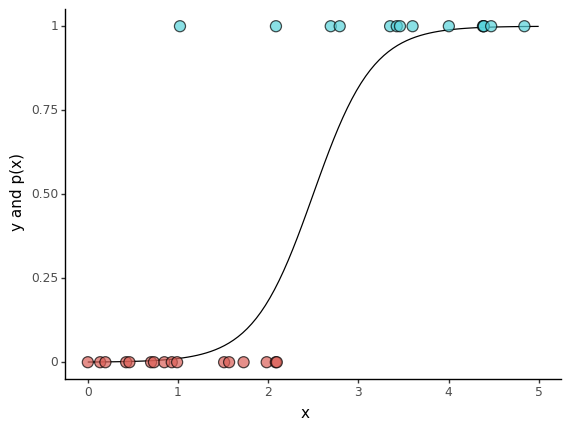

<ggplot: (8774218821455)>

In [21]:
import numpy as np
import pandas as pd
import plotnine as p9
from scipy.stats import uniform, bernoulli
# plotting functions are available at: 
from logistic.plots import plot_naive_logistic_fit

def logistic(x, k, x0):
    return 1 / (1 + np.exp(-k*(x - x0)))

def create_smooth_logistic_curve_data(k, x0, n_points=100):
    df = pd.DataFrame({'x': np.linspace(0, 5, n_points)})
    df['p_x'] = logistic(df['x'], k, x0)
    return df

def create_sample_data(k, x0, n_points, seed=1):
    np.random.seed(seed)
    df = pd.DataFrame({
        'x': uniform.rvs(loc=0, scale=5, size=n_points)
    }).sort_values('x', ignore_index=True)
    p_x = logistic(df['x'], k, x0)
    df['y'] = bernoulli.rvs(p_x)
    return df

sample_df = create_sample_data(k=3, x0=2.5, n_points=30)
smooth_px_df = create_smooth_logistic_curve_data(k=3, x0=2.5)

plot_naive_logistic_fit(sample_df, smooth_px_df)

This logistic curve $p(x)$ is described by two parameters:

- $x_0$ is the value of a predictor x for which the probability is 0.5 (mid-point): $p(x = x_0) = 0.5$, so tells us about the location of the mid-point.
- $k$ is related to the slope of the probability at mid-point: $(dp/dx)_{x = x_0} = k/4$, so tells us about the steepness of the curve at that mid-point. The larger the $k$, the steeper the curve in the middle.

If we naively employed ordinary least squares to fit the curve p(x) to these points, we would find that all residuals would be less than 1 and most points on the wrong side of the mid-point would have residuals ~ 1. It would make more sense to assign a much larger cost to points that are large outliers.:

Odds ratio (move to part 2)

$$\mathrm{log\ odds\ ratio} = \log \frac{\mathrm{odds}(x+1)}{\mathrm{odds}(x)} = \log \left[\frac{\frac{p(x+1)}{1-p(x+1)}}{\frac{p(x)}{1-p(x)}} \right]= k$$

Therefore, odds ratio is a ratio of ratios of probabilities. As you can tell, odds ratio is not the most intuitive measure, although that is what logistic regression estimates. If increasing x by one unit, increases the probability of y=1 from 0.1 (odds = 0.11) to 0.2 (odds = 0.25), that is represented by odds ratio of 0.25/0.1 = 2.27.

Keep in mind large odds ratio do not need to reflect large absolute probabilities. For example, if increasing x by one unit, increases the probability of y=1 from 0.0001 (odds = 0.0001) to 0.001 (odds = 0.001), this leads to odds ratio of 0.001/0.0001 = 10. So high odds ratio needs to be used with a grain of salt when the probability of y=1 is small. There are alternatives to odds ratio, such as [relative risk](https://www.statology.org/interpret-relative-risk/) which are more interpretable, but may not be simple to calculate or use for statistical inference.

We colored the points at $y = 0$ in <font color="#db5f57">red</font> and points at $y = 1$ in <font color="#57d3db">teal</font>.

## Log-loss fit

Instead of trying to make ordinary least squares work to fit $p(x)$ to the points, logistic regression proceeds differently:

* For <font color="#57d3db">teal</font> points at y = 1, we will fit $-\log p(x)$ instead of $p(x)$. Negative logarithm makes $-\log p(x)$ progressively larger; the closer p(x) gets to zero.

* For the <font color="#db5f57">red</font> points at $y=0$ we can do the same for the inverted probability, $-\log[1-p(x)]$.

We call these "log-losses". If we collapse all the points to $y = 0$, then for each point these two log-losses represent a cost (loss) of that point, for being some amount away from the log-loss curves. In order to utilize numpy vectorization, we will code these two together as a single log-loss function (this combo log-loss also goes by the name "cross entropy"):

In [22]:
def log_loss(p_x, y):
    return -y * np.log(p_x) - (1 - y) * np.log(1 - p_x)

One way to think about logistic regression is a method that simultaneously fits: $-\log p(x)$ for $y = 1$ and $-\log[1-p(x)]$ for $y = 0$.

How do these two log-loss curves look? 

To visualize them, we will plot the same data in the previous plot, but now with log-losses instead of probability:

In [23]:
def create_smooth_logloss_data(k, x0, n_points=100):
    x = np.linspace(0, 5, n_points)
    p_x = logistic(x, k, x0)
    return pd.DataFrame({
        'x': np.concatenate((x, x)),
        'y': np.concatenate(([0] * len(x), [1] * len(x))),
        'log_loss': np.concatenate((log_loss(p_x, 0), log_loss(p_x, 1))),
    })

def add_logloss(df, k, x0):
    p_x = logistic(df['x'], k, x0)
    return df.assign(log_loss = log_loss(p_x, df['y']))

def fit_data_to_logloss(sample_df, k, x0):
    sample_fit_df = add_logloss(sample_df, k, x0)
    logloss_df = create_smooth_logloss_data(k, x0)
    return (sample_fit_df, logloss_df)

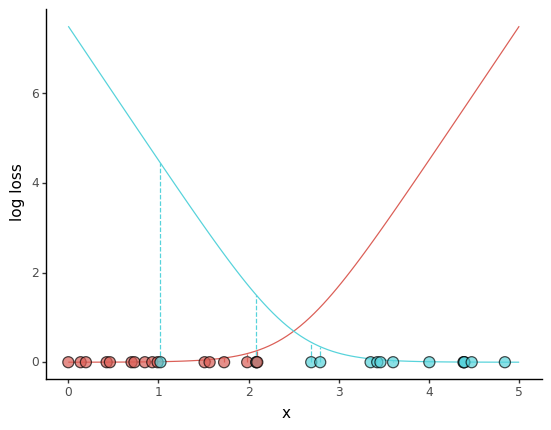

<ggplot: (8774217057323)>

In [24]:
from logistic.plots import plot_logistic_fit

sample_fit_df, logloss_df = fit_data_to_logloss(sample_df, k=3, x0=2.5)

plot_logistic_fit(sample_fit_df, logloss_df)

The fitting process is:

* <font color="#db5f57">Red points</font> ($y=0$) are fit to the <font color="db5f57">red "hockey stick" curve</font>: $-\log[1-p(x)]$.
* <font color="#57d3db">Teal points</font> ($y=1$) are fit to the <font color="#57d3db">teal "hockey stick" curve</font>: $-\log p(x)$.
* Both of these curves share the same parameters $k$ and $x_0$, so they change together.
* Sum of the vertical displacements between points is the total cost (or log-loss) that needs to be minimized for various combinations of $k$ and $x_0$

Here we collapsed all points to $y = 0$, but use the colors as y labels, since the values of log-losses on their own represent the cost. Red points ($y = 0$) are fit to the red hockey stick curve: $-\log[1-p(x)]$. Teal points ($y = 1$) are fit to the teal hockey stick curve: $-\log p(x)$. Sum of the vertical dashed lines represents the total log-loss that needs to be minimized for various $k$ and $x₀$.

Unlike probability, log-loss curves have the property of penalizing big outliers proportionally more and they do not have residuals that cap out at 1.

## Finding the minimal log-loss

How does changing $k$ and $x₀$ affect this fit? To answer this, we can run fits with various combinations of $k$ and $x₀$.

In [25]:
def fit_parameter_combinations(sample_df, combinations):
    sample_df_list = []
    logloss_df_list = []
    for k, x0 in combinations:
        sample_fit_df, logloss_df = fit_data_to_logloss(sample_df, k, x0)
        sample_fit_df['k'] = logloss_df['k'] = k
        sample_fit_df['x0'] = logloss_df['x0'] = x0
        sample_df_list.append(sample_fit_df)
        logloss_df_list.append(logloss_df)

    return (
        pd.concat(sample_df_list, ignore_index=True),
        pd.concat(logloss_df_list, ignore_index=True)
    )

Changing $x₀$ moves the intersection point sideways:

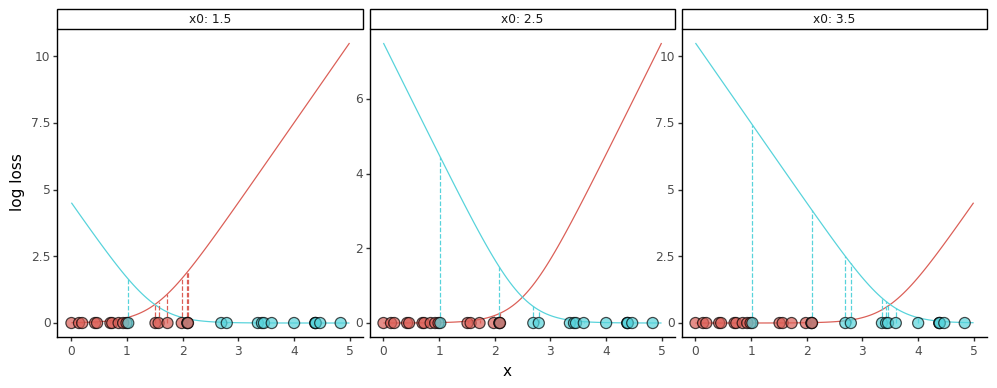

<ggplot: (8774221235643)>

In [26]:
from logistic.plots import plot_logistic_fit_panel

x0_dfs, x0_logloss_dfs = fit_parameter_combinations(
    sample_df,
    [(3, 1.5), (3, 2.5), (3, 3.5)]
)

plot_logistic_fit_panel(x0_dfs, x0_logloss_dfs, '~x0')

If $x₀$ is chosen away from the optimal point, the log-loss increases because increasing number of points gets fitted to the rising parts of the hockey sticks.

Changing k affects the steepness of the log-loss curves (note the different y axes):

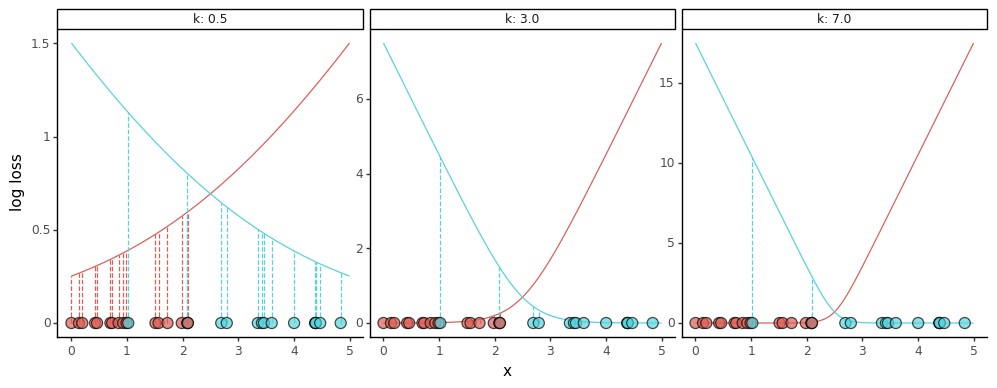

<ggplot: (8774216870672)>

In [27]:
k_dfs, k_logloss_dfs = fit_parameter_combinations(
    sample_df,
    [(0.5, 2.5), (3, 2.5), (7, 2.5)]
)
plot_logistic_fit_panel(k_dfs, k_logloss_dfs, '~k')

If $k$ is too low (0.5), most points add small but significant amounts to the total log-loss. If $k$ is too high (7.0), only the points on the "wrong side" contribute a significant amount to the total log-loss. In this case, it is the two teal points on the left of mid-point at $x₀ = 2.5$.

This brings up a question: what if there are no points on the "wrong side" of the mid-point, such as when the data is perfectly separated?

## Running the logistic model (Part 2)

Of course, in practice the algorithms for finding the optimal parameters are built into R/Python. We will use Python's `statsmodels` library. Just keep in mind: functions in these libraries parametrize the probability using $\beta$ s instead of $k$ and $x_0$ we used:

$$p(x) = \frac{1}{1 + e^{-k(x - x_0)}} = \frac{1}{1 + e^{-(\beta_1 x + \beta_0)}}$$

where the relationship between $k, x_0$ and $\beta_1, \beta_0$ is:

$$\beta_1 = k,\quad \beta_0 = - kx_0$$

so our model with $k=3$ and $x_0=2.5$ translates to $\beta_1=3$ and $\beta_0=-7.5$:

In [28]:
import statsmodels.formula.api as smf
model = smf.logit('y ~ x', sample_df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.230366
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   30
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 May 2023   Pseudo R-squ.:                  0.6666
Time:                        21:43:44   Log-Likelihood:                -6.9110
converged:                       True   LL-Null:                       -20.728
Covariance Type:            nonrobust   LLR p-value:                 1.466e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.6829      2.196     -2.588      0.010      -9.986      -1.380
x              2.6187      1.025      2.554      0.011       0.609       4.628
==============================================================================
"""

Since we have very few data points and because the seed was chosen to showcase an example with outliers, the fit is not perfect, but we can read out the model parameters:

$$\beta_1 = 2.6187, \quad \beta_0 = -5.6829$$

and the total log-loss is here reported as "Log-Likelihood", which is just negative total log-loss and equals -6.911.

## Limitations of logistic regression (Removed)

Since the parameters of the logistic model are obtained numerically (commonly using maximum likelihood estimation), this process can fail to converge for a number of reasons, such as:

1. large number of predictors $x_i$ compared to the number of samples
2. predictors that have high or perfect correlations
3. categorical predictors that contain a lot of missing categories
4. perfect separation 😮

Issues 1. and 2. can be corrected using various regularization methods or taking out problematic predictors from the model. Issue 3. can be fixed by re-grouping categories or in some other way filling in missing categories. Issue 4., perfect separation, is another cause for non-convergence, and an Achilles' heel of a logistic regression. It is difficult to resolve it directly - without switching to Bayesian logistic regression, so it warrants further discussion.

### Perfectly separated data

It turns out, the logistic model cannot fit data that is perfectly separated! 😮 We can apply what we learned earlier about fitting log-losses to understand why. We start by creating perfectly separated data (with $k = 3$ and $x₀ = 2.5$):

In [29]:
# Find perfectly separated data seed
# Remove from TDS post

perfect = False
seed = 100
while seed < 200:
    df = create_sample_data(3, 2.5, 30, seed)
    if np.array_equal(df['y'].values, np.sort(df['y'].values)):
        print("Good seed: "+str(seed))
    seed += 1


Good seed: 101
Good seed: 112
Good seed: 113
Good seed: 116
Good seed: 119
Good seed: 121
Good seed: 126
Good seed: 135
Good seed: 143
Good seed: 147
Good seed: 152
Good seed: 154
Good seed: 155
Good seed: 158
Good seed: 176
Good seed: 191
Good seed: 194


Total log-loss:  1.4776889859527733


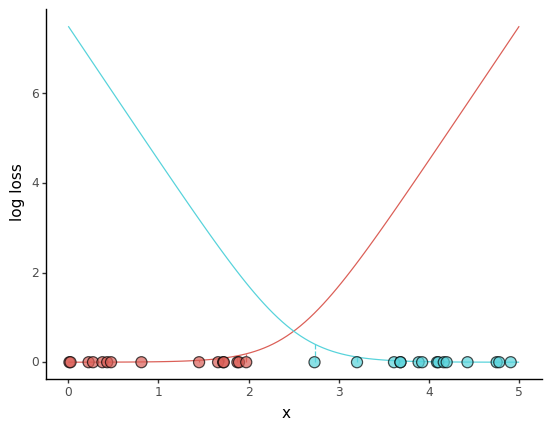

<ggplot: (8774216735398)>

In [30]:
perfect_df = create_sample_data(k=3, x0=2.5, n_points=30, seed=112)

perfect_sep_df, perfect_sep_logloss_df = fit_data_to_logloss(
    perfect_df,
    k=3,
    x0=2.5
)

print("Total log-loss: ", perfect_sep_df['log_loss'].sum())

plot_logistic_fit(perfect_sep_df, perfect_sep_logloss_df)

Remember how changing $k$ affects these hockey stick log-loss curves? When we increased $k$, the main contribution to the total log-loss was from the points in the "wrong side" of the mid-point. Now, all points are on the "correct side" of the mid-point.

That means that we can create arbitrarily good fits by continuously increasing $k$. Here is how the fits look when we set $k = 13$:

Total log-loss:  0.050774866143719344


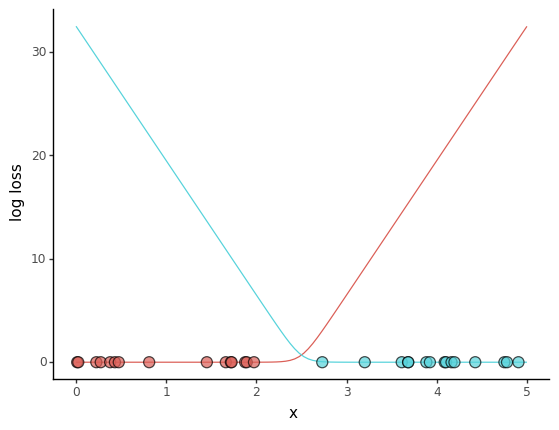

<ggplot: (8774216692727)>

In [31]:
perfect_df = create_sample_data(k=3, x0=2.5, n_points=30, seed=112)

perfect_sep_df, perfect_sep_logloss_df = fit_data_to_logloss(
    perfect_df,
    k=13,
    x0=2.5
)

print("Total log-loss: ", perfect_sep_df['log_loss'].sum())

plot_logistic_fit(perfect_sep_df, perfect_sep_logloss_df)

Fitting perfectly separated data would require log-losses to have a 90-degree angle and fitted probability to have an infinite slope at the mid-point. Therefore, there is no parameter k for which total log-loss has a minimum. In practice, numerical algorithms stop after some number of steps and may either return the value of k in the last step or an error.

## Perfectly separated data statsmodels (Part 2)

We can verify this using `statsmodels`:

In [32]:
warnings.filterwarnings('default')

In [33]:
# perfect_sep_model = smf.logit('y ~ x', perfect_sep_df).fit()
# perfect_sep_model.summary()

Since the model did not converge, it probably should have returned an error, not an innocent warning. Logistic model function in R, `glm(..., family=binomial)` does the same. To quote [R Inferno](https://www.burns-stat.com/pages/Tutor/R_inferno.pdf), Circle 5, Consistency:

> There is a problem with warnings. No one reads them. People have to read
> error messages because no food pellet falls into the tray after they push the
> button. With a warning the machine merely beeps at them but they still get
> their food pellet. Never mind that it might be poison.

Therefore, be careful when doing inference using effect sizes and p-values. In this case the data is perfectly separable - we have a perfect predictor! While the reported p-value ($P > |z|$) is 0.997. Ignoring or misunderstanding these warnings may get you miss some obvious features in the data.

Alternatively, consider simply using a different model. There is a brave new world outside of logistic regression.

## Comment on sklearn LogisticRegression

`sklearn` is a great Python library. It automates and abstracts much of the calculations and provides a simple and consistent way to run many different models. However, in doing so, it does hide a number of things happening in the background. So learning data science concepts from `sklearn` documentation can lead to some misunderstanding.

One of these is that `sklearn.linear_model.LogisticRegression()` by default, using `.predict()` method, _acts_ like a classification model:

In [34]:
from sklearn.linear_model import LogisticRegression

sklearn_logistic = LogisticRegression(penalty=None).fit(
    sample_df['x'].values.reshape(-1, 1),
    sample_df['y'].values,
)

print("Predicted outcomes: ")
sklearn_logistic.predict(
    sample_df['x'].values.reshape(-1, 1)
)

Predicted outcomes: 


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

Keep in mind that `LogisticRegression()` by default uses L2 regularization, which adds an extra term to the log-loss function. To make it comparable with `statsmodels`, use `LogisticRegression(penalty=None)`. Here, it will not matter since we only have one predictor, but if we have two or more, it will give different parameter estimates. Model parameters are available in the model object:

In [35]:
print("beta_1 or log-odds-ratio: ", sklearn_logistic.coef_[0][0])
print("beta_0 or y intercept: ", sklearn_logistic.intercept_[0])

beta_1 or log-odds-ratio:  2.6187462367743803
beta_0 or y intercept:  -5.682896087072998


Under the hood, what `.predict()` does is predicts the outcome based on the larger of the two probabilities: $p$ or $1-p$. If $p > 1-p$ then it predicts 1, otherwise predicts 0. It does not calculate confidence intervals, does not have p-values and does not do any kind of statistical inference or hypothesis testing.

## Conclusion

In this post we tried to give an intuitive explanation to logistic regression, show how to run regression models in Python's `statsmodels` and `scikit-learn` libraries.

Take home points:

* Logistic regression outputs a probability - therefore it is a regression algorithm.
* Logistic regression can be used for classification.
* Parameters are estimated numerically using the difference between data and two "crossed hockey sticks" log-loss curves that serve as a cost function.
* Use `statsmodels` to run a logistic regression when you are interested in statistical inference (hypothesis testing, p-values, etc.)
* Use `scikit-learn` to run a logistic regression when you just want to try predict the outcome.
* Perfectly separable data cannot be modeled using a logistic model. We still get some large odds-ratio - which depends whenever numerical algorithm stops. So it may be used for prediction but the confidence intervals and p-values will be misleading.

I hope this helps you in your data science journey!